# Optimal Risk Sharing with Participation Constraints


#### Pau Belda, June 2022

In this note, a model of optimal risk sharing with participation constraints is solved using the Lagrangean method outlined by Marcet and Marimon (2019). 

First, a model of optimal risk sharing with full commitment is solved. Then, full commitment is replaced by a participation constraint.

## Risk sharing with full commitment

Consider a Social Planner that faces this problem: 

\begin{equation}
      \max_{\substack{\{C_t^1, C_t^2\}_{t=0}^\infty}} \mathbb{E}_0 \sum_{t=0}^\infty \delta^t \lambda ln(C_t^1) + (1-\lambda) ln(C_t^2)
\end{equation}
s.t. 
Feasibility: 
\begin{equation}
    C_t^1 + C_t^2 = W_t^1 + W_t^2 
\end{equation}

Agent 1 income process: 
\begin{equation}
   \text{ln} W_t^1 = a + \theta \text{ln} W_{t-1}^1 + \epsilon_t
\end{equation}
with 
\begin{equation*}
    \epsilon_t \sim \mathcal{N} (0, \sigma^2)
\end{equation*}

##### Equilibrium conditions
i) Feasibility: 
\begin{equation}
      C_t^1 + C_t^2 = W_t^1 + W_t^2
\end{equation}
ii) Consumption smoothing:
\begin{equation}
      \frac{C_t^2}{C_t^1} = \frac{(1-\lambda)}{\lambda}
\end{equation}

* There is full risk-sharing: all idiosyncratic risk is eliminated.

##### Simulation

(0.4, 0.6)

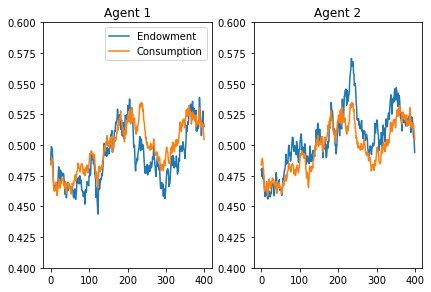

In [15]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.optimize import least_squares


#Parameters
theta=0.98 #endowments persistence
a=np.log(0.5)*(1-theta) #Calibrated to get exp(ln w) = exp(a/(1-theta))=0.5 = 
sigma=0.01 #shocks std. deviation
N=10000
weight1=0.5
beta=0.99 #discount factor


"""Stochastic endowments"""
np.random.seed(10) #Reproducible simulation

#---- shocks -----
mean, cov = [0, 0], [(sigma**2, 0), (0, sigma**2)]
shocks = np.random.multivariate_normal(mean, cov, N)


#Endowments
w1=np.ones((N))*0.5
w2=np.ones((N))*0.5
for t in range(1,N):
    w1[t]=np.exp(a + theta*np.log(w1[t-1]) + shocks[t,0])
    w2[t]=np.exp(a + theta*np.log(w2[t-1]) + shocks[t,1])


#Optimal consumption
c1=np.ones((N))
c2=np.ones((N))

for t in range(N):
    c2[t]= (w1[t] + w2[t])/(1 + weight1/(1-weight1))
    c1[t]= w1[t] + w2[t] - c2[t]

    
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(w1[400:800], label='Endowment')
ax[0].plot(c1[400:800], label='Consumption')
ax[0].set_title('Agent 1')
ax[0].set_ylim([0.4,0.6])
ax[0].legend()

ax[1].plot(w2[400:800])
ax[1].plot(c2[400:800])
ax[1].set_title('Agent 2')
ax[1].set_ylim([0.4,0.6])

## Risk sharing with a participation constraint

Before agents would commit to never leave the risk-sharing arrangement. Instead, now they decide each period whether to stay or go, evaluating their outside option. 

A Pareto-optimal risk-sharing contract with PC can be found by solving the following problem: 

\begin{equation}
      \max_{\substack{\{C_t^1, C_t^2\}_{t=0}^\infty}} \mathbb{E}_0 \sum_{t=0}^\infty \delta^t \lambda ln(C_t^1) + (1-\lambda) ln(C_t^2)
\end{equation}
s.t. 
Feasibility: 
\begin{equation}
    C_t^1 + C_t^2 = W_t^1 + W_t^2 
\end{equation}

Participation constraint for i=1,2:
\begin{equation}
  \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(C_{t+j}^i) \geq V_t^i
\end{equation}

with the outside option being
\begin{equation}
  V_t^i = \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(W_{t+j}^i)
\end{equation}

Using the Marcet and Marimon (2019)'s approach, the Lagrangean of the previous problem can be recast in a recursive way:
\begin{equation}
 \mathcal{L} = \mathbb{E}_0 \sum_{t=0}^\infty \delta^t (\lambda + \mu_t^1) ln(C_t^1) + (1-\lambda + \mu_t^2) ln(C_t^2)
\end{equation}
s.t. 
\begin{equation}
    \mu_t^i = \mu_{t-1}^i + \gamma_t^i
\end{equation}
with $\mu_{-1}=0$ and $\gamma_t^i \geq 0$ for i=1,2. 

In this case, the co-state variable $\mu$ captures the value of past commitments. 


##### Equilibrium conditions

i) Feasibility: 
\begin{equation}
    C_t^1 + C_t^2 = W_t^1 + W_t^2
\end{equation}

ii) Risk-sharing:
\begin{equation}
    \frac{C_t^2}{C_t^1} = \frac{1-\lambda + \mu_t^2}{\lambda + \mu_t^1}
\end{equation}

iii) Slackness of the participation constraint (for i=1,2):
\begin{equation}
    \gamma_t^i\Bigg(ln(C_t^i) + \beta \mathbb{E}_t \sum_{j=0}^\infty \beta^j ln(C_{t+1+j}^i) - V_t^i\Bigg)=0
\end{equation}
with $\gamma_t^i \geq 0$. 

iv) Commitment updating (for i=1,2):
\begin{equation}
   \mu_t^i = \mu_{t-1}^i + \gamma_t^i 
\end{equation}


#### Algorithm to solve and simulate the model

1.- Simulate a long series of shocks $\{\epsilon_t^i\}_{t=0}^T$ for i=1,2. Get the endowments $\{W_t^i\}_{t=0}^T$ for i=1,2. 

2.- Guess some values for the parameters $\eta$. 

3.- Solve for equilibrium consumption presuming no agent is constrained (that is,  assuming $\mu_t^i = \mu_{t-1}^i$ for all i). Then, risk-sharing and feasibility conditions deliver $(\bar{C_t^1}, \bar{C_t^2})$.


4.- Check the Participation Constraint. 

  4.1.- Compute the outside option's value. The chosen process implies 
    \begin{equation}
         V_t^i = \frac{a\beta}{1-\beta} + \Big(1 + \frac{\beta \theta}{1-\beta\theta a}\Big)ln(W_t^i)
    \end{equation}
   
   4.2.- Parameterize the expected discounted sum of future utility of participation: 
    \begin{equation}
            ln(C_t^i) + \beta \mathbb{E}_t \sum_{l=0}^\infty \beta^l ln(C_{t+1+l}^i)  = ln(C_t^i) + \beta \psi({x_t}; {\eta})
    \end{equation}
  where ${x_t} = \{W_t^1, W_t^2, \mu_{t-1}^1, \mu_{t-1}^2\}$ are the     states at time t and $\eta$ a vector of parameters.      
  
  4.3.- Check the constraint. There are 3 cases:
  
  **Case 1**: None of the PC is binding. Then, $(\bar{C_t^1}, \bar{C_t^2}) = ((C_t^1)^*, (C_t^2)^*)$.
  
  **Case 2**: $PC^i$ is binding, $PC^j$ is not. In this case, 
  
  i) Recover $(C_t^i)^*$ from $PC^i$:
  \begin{equation}
        (C_t^i)^* = exp\Big\{V_t^i - \beta \psi({x_t}; {\eta})\Big\}
  \end{equation}
  
  ii) Recover $(C_t^j)^*$ from feasibility:
  \begin{equation}
      (C_t^j)^* = W_t^i + W_t^j - (C_t^i)^*
  \end{equation}
  
  iii) Since $PC^j$ is not binding, $\gamma_t^j = 0$ and $\mu_t^j = \mu_{t-1}^j$. 
  
  iv) Recover $\mu_t^i$ from the optimal risk-sharing condition: 
  \begin{equation}
        \mu_t^i = (C_t^i)^* \Big(\frac{\lambda^i + \mu_t^j}{(C_t^j)^* }\Big) - \lambda^i 
   \end{equation}
   with $\lambda^1 = \lambda$ and $\lambda^2 = 1- \lambda$. 
   
   
   **Case 3**: Both PCs are binding. In this case,
   
   i) Recover $(C_t^i)^*$ from the $PC^i$.
   
   ii) Recover $(C_t^j)^*$ from feasibility. 
   
   iii) Update $\mu_t^i$ for i=1,2. For that,
   
   a) Recover $\gamma_t^i$ from 
   \begin{equation}
    \gamma_t^i\Bigg(ln(C_t^i) + \beta \mathbb{E}_t \sum_{l=0}^\infty \beta^l ln(C_{t+l+1}^i) - V_t^i\Bigg)=0
\end{equation}
 with $\gamma_t^i \geq 0$. Alternative? Guess $\gamma_t^i > 0$?  
  
   b) Update $\mu_t^i = \mu_{t-1}^i - \gamma_t^i$. 
   
   c) Use the risk-sharing condition to get $\mu_t^j$, using the already computed values $\mu_t^i$, $(C_t^i)^*$, $(C_t^j)^*$:
     \begin{equation}
        \mu_t^j = (C_t^j)^* \Big(\frac{1-\lambda + \mu_t^i}{(C_t^i)^* }\Big) -(1- \lambda)
   \end{equation}
   

5.- Get the right $\eta$ using PEA. 

5.1.- Compute a non-linear regression:
    \begin{equation*}
        G(\eta) = \underset{\nu \in \mathbb{R}^n}{\operatorname{argmin}} \sum_{i=1,2} \frac{1}{(T-\underline{T})}\sum_{t=\underline{T}}^{T}\Bigg[\sum_{l=0}^M \beta^l ln(C_{t+l+1}(\eta)^i)- \psi\Big(x_t(\eta); \nu\Big)\Bigg]^2
      \end{equation*}
  
 5.2.- Update the coefficients:
 \begin{equation*}
        \eta ^{s+1} = \eta^s + d(G(\eta^s) - \eta^s)
        \end{equation*}
    and redo 3 to 5.1. until reaching a fixed point $\eta_f =  G(\eta_f)$. 

In [16]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.optimize import least_squares


#Parameters
theta=0.98 #endowments persistence
sigma=0.01 #shocks std. deviation
N=10000
weight1=0.4
a=-0.015
beta=0.99 #discount factor
Horizon=500 
Initial=500


"""Stochastic endowments"""
np.random.seed(10) #Reproducible simulation

#---- shocks -----
mean, cov = [0, 0], [(sigma**2, 0), (0, sigma**2)]
shocks = np.random.multivariate_normal(mean, cov, N)

#Endowments
w1=np.ones((N))*0.5
w2=np.ones((N))
for t in range(1,N):
    w1[t]=np.exp(a + theta*np.log(w1[t-1]) + shocks[t,0])
    #w2[t]=1-w1[t]
    w2[t]=np.exp(a + theta*np.log(w2[t-1]) + shocks[t,1])



""" Parameterized Expectations """
def poly(eta0, eta1,eta2, eta3,eta4, w1, w2, mu1, mu2):
    return eta0*np.exp(eta1*w1 + eta2*w2 + eta3*mu1 + eta4*mu2)

"""Non-linear equations system"""
def sim(X, c1, c2, u1, v1, u2, v2, mu11, mu21 ):
    mu1=X[0]
    mu2=X[1]
    gamma1=X[2]
    gamma2=X[3]
    F0 = c2 - (((1-weight1)+mu2)*c1)/(weight1 + mu1)
    F1 = gamma1*(u1 - v1)
    F2 = gamma2*(u2 - v2)
    F3 = mu1 - mu11- gamma1
    #F4 = mu2 - mu21- gamma2
    
    return F0, F1, F2, F3



etas=np.ones((10))
def PEA(etas):
    global c1, c2, mu1, mu2
    
    eta01=etas[0]
    eta11=etas[1]
    eta21=etas[2]
    eta31=etas[3]
    eta41=etas[4]

    eta02=etas[5]
    eta12=etas[6]
    eta22=etas[7]
    eta32=etas[8]
    eta42=etas[9]
  
    """ Simulation"""
    mu1=np.zeros((N))
    mu2=np.zeros((N))
    c1=np.zeros((N))
    c2=np.zeros((N))
    v1=np.zeros((N))
    v2=np.zeros((N))
    u1=np.zeros((N))
    u2=np.zeros((N))
    gamma1=np.zeros((N))
    gamma2=np.zeros((N))

    v1=np.log(w1)
    v2=np.log(w2)
    
    count=np.zeros((N))
       
    for t in range(1,N):
        c1[t]=(weight1 + mu1[t-1])/(mu1[t-1] + mu2[t-1] + 1)
        c2[t]=w1[t]+w2[t]-c1[t]
        
        mu1[t]=mu1[t-1]
        mu2[t]=mu2[t-2]
    
        #------------- Check the Participation constraint       
        #Outside option
        v1[t]=a*beta/(1-beta) + (1+(beta*theta/(1-beta*theta*a)))*np.log(w1[t])
        v2[t]=a*beta/(1-beta) + (1+(beta*theta/(1-beta*theta*a)))*np.log(w2[t])
        
        #Expected utility of participating
        u1[t]=np.log(c1[t]) + beta*poly(eta01, eta11, eta21, eta31, eta41, w1[t], w2[t], mu1[t-1], mu2[t-1])
        u2[t]=np.log(c2[t]) + beta*poly(eta02, eta12, eta22, eta32, eta42, w1[t], w2[t], mu1[t-1], mu2[t-1])
        
        #Check cases:
        #Case 2.1: PC1 is binding; PC2 is not
        if u1[t]<=v1[t] and u2[t]>v2[t]:
            c1[t]=np.exp(v1[t] - beta*poly(eta01, eta11, eta21, eta31, eta41, w1[t], w2[t], mu1[t-1],mu2[t-1]))
            c2[t]=w1[t]+w2[t]-c1[t]
            mu2[t]=mu2[t-1]
            mu1[t]=(c1[t]*(1-weight1 + mu2[t])/c2[t])-weight1
            
        #Case 2.2: PC2 is binding; PC1 is not
        if u2[t]<=v2[t] and u1[t]>v1[t]:
            c2[t]=np.exp(v2[t] - beta*poly(eta02, eta12, eta22, eta32, eta42, w1[t], w2[t], mu1[t-1],mu2[t-1]))
            c1[t]=w1[t] + w2[t] -c2[t]
            mu1[t]=mu1[t-1]
            mu2[t]=(c2[t]*(weight1 + mu1[t])/c1[t])- (1-weight1)
        
        #Case 3: Both binding
        if u2[t]<=v2[t] and u1[t]<=v1[t]:
            c1[t]=np.exp(v1[t] - beta*poly(eta01, eta11, eta21, eta31, eta41, w1[t], w2[t], mu1[t-1],mu2[t-1]))
            #c2[t]=np.exp(v2[t] - beta*poly(eta02, eta12, eta22, eta32, eta42, w1[t], w2[t], mu1[t-1],mu2[t-1]))
            c2[t]=w1[t]+w2[t]-c1[t]
        
        
            """
            #Positive multiplier
            gamma11=0.01
            mu1[t]=mu1[t-1] + gamma11
            mu2[t]=(c2[t]*(weight1 + mu1[t])/c1[t])- (1-weight1)
            """
            
            
            #Solve a non-linear equation system
            x0 = [mu1[t-1],mu2[t-1], gamma1[t-1], gamma2[t-1]]
            sol = least_squares(sim,x0,args=(c1[t],c2[t], u1[t], v1[t], u2[t], v2[t],mu1[t-1],mu2[t-1]), bounds=([0,0,0,0], [10,10,10,10]))
            mu1[t]=sol.x[0]
            mu2[t]=sol.x[1]
            gamma1[t]=sol.x[2]
            gamma2[t]=sol.x[3]
            
            
            count[t]=1

        
        
    """                           EE errors              """ 
    error1=np.ones((N))   
    error2=np.ones((N))  
    lhs1=np.ones((N))   
    rhs1=np.ones((N)) 
    lhs2=np.ones((N))   
    rhs2=np.ones((N))   
    
    rhs1=np.log(c1)
    rhs2=np.log(c2)
   
    for t in range(N):
        #agent 1
        for j in range(N-t-1):
            rhs1[t]=rhs1[t] + pow(beta,j)*np.log(c1[t+j+1])
            
        lhs1[t]=poly(eta01, eta11, eta21, eta31, eta41, w1[t], w2[t], mu1[t-1],mu2[t-1])
        error1[t]=pow(lhs1[t]-rhs1[t],2)
        
        #agent 2 
        for j in range(N-t-1):
            rhs2[t]=rhs2[t] + pow(beta,j)*np.log(c2[t+j+1])
            
        lhs2[t]=poly(eta02, eta12, eta22, eta32, eta42, w1[t], w2[t], mu1[t-1],mu2[t-1])
        error2[t]=pow(lhs2[t]-rhs2[t],2)
        
    ssr=np.nanmean(error1[Initial:-Initial]) + np.nanmean(error2[Initial:-Initial])
    
    return ssr 



"""Compute the PEA coefficients"""
z=np.ones((10))
toler = 0.01
diff = [1, 1, 1, 1, 1, 1, 1, 1,1,1]
d = 0.01  # gain
j = 1

while abs(max(diff)) > toler:
    
    # New estimate
    z_estimate = optimize.fmin(PEA, z, xtol=0.01, ftol=0.01, maxfun=10000)  # Nelder–Mead method
    #solution2=optimize.minimize(PEA,z,tol=0.001)
   
    z_estimate=solution2.x
    
    # Update
    new_z = z + d*(z_estimate - z)

    diff = z_estimate - z
    z = new_z
    j = j + 1